(636106, 11)


<AxesSubplot:xlabel='x', ylabel='y'>

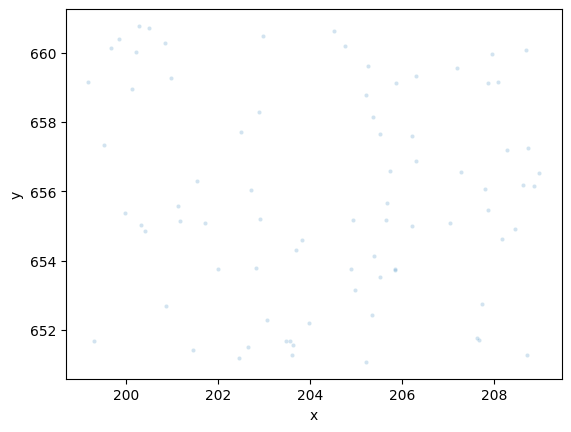

In [2]:
import h5py
import pandas as pd
import numpy as np
import seaborn as sns

locs = pd.read_hdf('/home/miguel/Projects/uni/data/smlm_3d/20230215_nup_motic_largeFOV/storm_1_MMStack_Default_1.ome_locs.hdf5', key='locs')
print(locs.shape)

# with h5py.File('/home/miguel/Projects/uni/data/smlm_3d/20230215_nup_motic_largeFOV/storm_1_MMStack_Default_1.ome_spots.hdf5') as f:
#     spots = np.array(f['spots'])
x = 204
y = 656
bound = 5
locs = locs[(x-bound < locs['x']) & (locs['x'] < x+bound)]
locs = locs[(y-bound < locs['y']) & (locs['y'] < y+bound)]
sns.scatterplot(data=locs, x='x', y='y', marker='.', alpha=0.2)



In [3]:
from data.visualise import grid_psfs, show_psf_axial


2023-06-13 12:40:14.467907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(187, 31, 31)
(187, 12)
(187, 151, 31, 31)


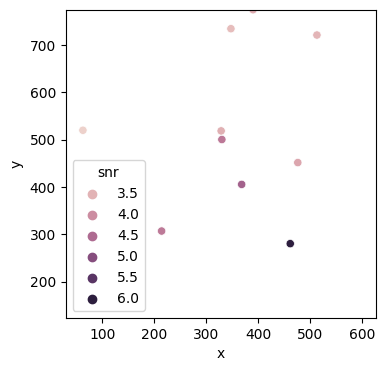

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd

import sys
from tifffile import imread
import h5py
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/home/miguel/Projects/uni/phd/smlm_z/smlm-z/src/smlm_z/pipelines')
try:
    from preprocessing.nodes import extract_training_stacks
except ImportError:
    from preprocessing.nodes import extract_training_stacks

bead_stacks = [
    '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_5/3um_stack_20nm_step_20nm_bead_5_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_3/3um_stack_20nm_step_20nm_bead_3_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_9/3um_stack_20nm_step_20nm_bead_9_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_7/3um_stack_20nm_step_20nm_bead_7_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_6/3um_stack_20nm_step_20nm_bead_6_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_2/3um_stack_20nm_step_20nm_bead_2_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_4/3um_stack_20nm_step_20nm_bead_4_MMStack_Default.ome.tif',
#     '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/3um_stack_20nm_step_20nm_bead_8/3um_stack_20nm_step_20nm_bead_8_MMStack_Default.ome.tif',
]

all_spots = []
all_locs = []
all_stacks = []
for bead_stack_path in bead_stacks:
    bead_stack = imread(bead_stack_path)
    slice_path = bead_stack_path.replace('.ome', '_slice.ome')
    spots_path = slice_path.replace('.tif', '_spots.hdf5')
    with h5py.File(spots_path) as f:
        spots = np.array(f['spots'])

    locs_path = spots_path.replace('_spots', '_locs')
    locs = pd.read_hdf(locs_path, key='locs')

    from skimage.feature import match_template

    parameters = {
        'picasso': {
            'spot_size': 31,
            'localised_frame': bead_stack.shape[0]//2
        },
        'DEBUG': False
    }
    stacks = extract_training_stacks(spots, bead_stack, parameters)

    all_spots.append(spots)
    all_locs.append(locs)
    all_stacks.append(stacks)

min_stack_length = min(list(map(lambda s: s.shape[1], all_stacks)))
all_stacks = [s[:, :min_stack_length] for s in all_stacks]

spots = np.concatenate(all_spots)
locs = pd.concat(all_locs)
stacks = np.concatenate(all_stacks)

print(spots.shape)
print(locs.shape)
print(stacks.shape)
max_pixel_val = np.max(stacks, axis=(1,2,3))
mean_pixel_val = np.median(stacks, axis=(1,2,3))
snr = max_pixel_val / mean_pixel_val
locs['snr'] = snr

locs = locs.reset_index(drop=True)

# for i in np.argsort(snr):
#     if snr[i] > 3:
#         show_psf_axial(stacks[i], snr[i])
    
plt.rcParams["figure.figsize"] = (4, 4)

import seaborn as sns
sns.scatterplot(data=locs[locs['snr'] > 3], x='x', y='y', hue='snr')
plt.xlim(locs['x'].min(), locs['x'].max())
plt.ylim(locs['y'].min(), locs['y'].max())
plt.show()


idx = locs['snr'] > 3
locs = locs[idx]
spots = spots[idx]
stacks = stacks[idx, :150]


In [5]:
# from tifffile import imwrite
# import pandas as pd

# locs.to_hdf('/home/miguel/Projects/uni/data/smlm_3d/combined_stacks/locs.hdf5', key='locs')
# imwrite('/home/miguel/Projects/uni/data/smlm_3d/combined_stacks/training_stacks.ome.tif', stacks, compress=6)

In [6]:
locs.shape, stacks.shape

((10, 13), (10, 150, 31, 31))

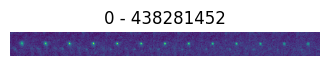

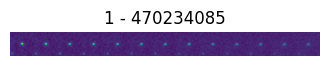

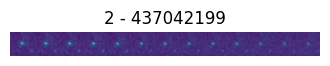

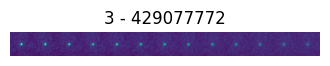

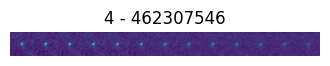

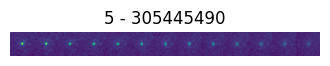

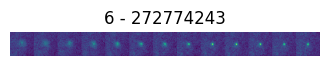

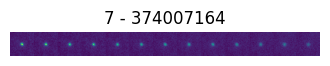

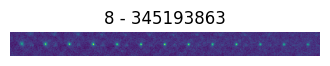

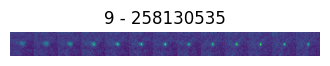

In [7]:
for i in range(stacks.shape[0]):
    show_psf_axial(stacks[i], f'{str(i)} - {stacks[i].sum()}')

In [8]:
stacks[0].sum(axis=(1,2))

array([2805660, 2807868, 2798419, 2795318, 2795862, 2825209, 2820706,
       2819322, 2798698, 2773185, 2816498, 2842157, 2842957, 2794588,
       2799324, 2820245, 2865747, 2882497, 2860854, 2813770, 2834775,
       2839705, 2877964, 2862214, 2855338, 2853952, 2828389, 2860391,
       2856385, 2876724, 2852899, 2854334, 2862271, 2868406, 2887603,
       2900926, 2859892, 2855465, 2872283, 2858575, 2898233, 2892181,
       2871392, 2859282, 2886190, 2901684, 2895606, 2899976, 2868650,
       2872465, 2907024, 2911094, 2919204, 2889639, 2874000, 2903652,
       2945646, 2916265, 2912141, 2898926, 2899001, 2931015, 2915047,
       2933302, 2907196, 2908556, 2888423, 2927761, 2930230, 2936501,
       2946022, 2939083, 2930017, 2937537, 2928748, 2950254, 2950355,
       2945339, 2946662, 2932572, 2922860, 2940323, 2956569, 2947190,
       2961157, 2916420, 2907340, 2924184, 2943463, 2920019, 2964971,
       2923066, 2903642, 2928016, 2974100, 2940560, 2964718, 2922105,
       2916858, 2933

In [9]:
RANDOM_SEED = 42


target_spot = 5

target_psf = stacks[target_spot].copy()
df = locs

z_step = 0.02
z_range = target_psf.shape[0] * z_step / 2
print(target_psf.shape)
print(z_step)
print(z_range)

optical_params = dict(Nn=31, 
                          pixel_size=0.115, 
                          zrange=z_range, 
                          dz=z_step, 
                          magnification=111.11,
                          ill_NA=1.4,
                          det_NA=1.3,
                          n=1.335,
#                           fwhmz=3.0,
                          ill_wavelength=635,
                          det_wavelength=635)



print(target_psf.min(), target_psf.max())


(150, 31, 31)
0.02
1.5
1210 9647


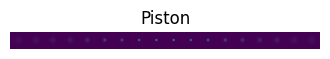

Time taken: 0.283s


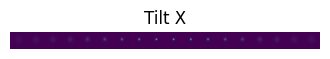

Time taken: 0.052s


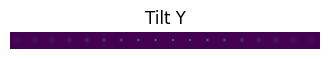

Time taken: 0.052s


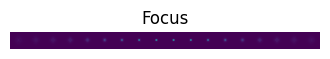

Time taken: 0.052s


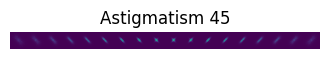

Time taken: 0.054s


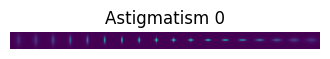

Time taken: 0.053s


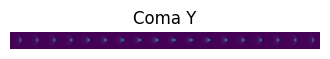

Time taken: 0.052s


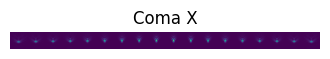

Time taken: 0.053s


In [10]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.01'

import jax.numpy as jnp
import jax
import numpy as np

def rms2(ab, pupil):
    return np.sqrt(np.sum(ab**2) / np.sum(pupil <= 1))


try:
    import cupy as cp

    print('cupy imported')
    import_cp = True
except:
    import_cp = False

import matplotlib.pyplot as plt


def rms(pupil):
    return jnp.sqrt(jnp.mean(jnp.abs(pupil)**2))
          
def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())


import poppy 

KR = None
THETA = None
class Simulator:
    
    
# pixel size (nm) - 115
# step size (nm) - 20nm
# magnification - 100x
# illumination NA
# NA at sample
# refractive index at sample - PBS so 1.335
# illumination wavelength - 635nm
# detection wavelength - to check


# #     N = 2048  # points to use in FFT
#     Nn = 32
#     pixel_size = 0.115  # camera pixel size
#     zrange = 1.0  # distance either side of focus to calculate, in microns, could be arbitrary
#     dz = 0.02  # step size in axial direction of PSF
    
#     magnification = 100  # objective magnification
#     ill_NA = 1.4  # numerical aperture at illumination beams
#     det_NA = 1.1  # numerical aperture at sample
#     n = 1.335  # refractive index at sample
#     fwhmz = 3.0  # FWHM of light sheet in z

#     ill_wavelength = 635  # illumination wavelength in nm
#     det_wavelength = 635  # detection wavelength in nm

    def __init__(self, Nn=32, n_coefs=32, pixel_size=0.90, zrange=1.0, dz=0.02, magnification=100, ill_NA=1.4, det_NA=1.1, n=1.335, ill_wavelength=635, det_wavelength=635):
        self.Nn = Nn # lateral size of output PSF
        self.pixel_size = pixel_size
        self.zrange = zrange
        self.dz = dz # step size in axial direction of PSF
        self.magnification = magnification
        self.ill_NA = ill_NA # numerical aperture at illumination beams
        self.ill_wavelength = ill_wavelength # illumination wavelength in nm
        self.det_NA = det_NA # numerical aperture at sample
        self.det_wavelength = det_wavelength # detection wavelength in nm
        
        self.n = n # refractive index at sample
#         self.fwhmz = fwhmz
        
        
#         np.random.seed(RANDOM_SEED)
        # self.seed(1234)  # set random number generator seed
        self.ill_wavelength = self.ill_wavelength * 1e-3
        self.det_wavelength = self.det_wavelength * 1e-3
#         self.sigmaz = self.fwhmz / 2.355
        self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
        self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
#         self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        
        self.N = self.Nn * (self.det_wavelength / (4 * self.det_NA)) / (self.pixel_size / self.magnification)

        self.dxn = self.N * self.dx / self.Nn  # correct spacing
        self.res = self.det_wavelength / (2 * self.det_NA)
        oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
        self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
        self.k0 = 2 * jnp.pi * self.n / self.det_wavelength
        self.kx, self.ky = jnp.meshgrid(jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
                                       jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
        self.kr = jnp.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
        
        self.krmax = self.det_NA * self.k0 / self.n
        self.kr2 = self.kx ** 2 + self.ky ** 2
        self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

        self.alpha = jnp.arcsin(self.det_NA / self.n)
        # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
        self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - jnp.cos(self.alpha)))
        self.Nz = int(2 * jnp.ceil(self.zrange / self.dz))
        self.dz = 2 * self.zrange / self.Nz
        self.Nzn = int(2 * jnp.ceil(self.zrange / self.dzn))
        self.dzn = 2 * self.zrange / self.Nzn
        if self.Nz < self.Nzn:
            self.Nz = self.Nzn
            self.dz = self.dzn
        else:
            self.Nzn = self.Nz
            self.dzn = self.dz
            
        self.n_coefs = n_coefs
        self.zerns = jnp.zeros((n_coefs, Nn, Nn))

        theta = jnp.arctan2(self.ky, self.kx)
        
        masked_pupil = np.array(self.kr)
        masked_pupil[masked_pupil > 1] = 0
        masked_pupil = norm_zero_one(masked_pupil)
        
        KR = np.array(self.kr)
        THETA = np.array(theta)
#         plt.imshow(KR)
#         plt.colorbar()
#         plt.show()
#         plt.imshow(THETA)
#         plt.colorbar()
#         plt.show()
        
        for i in range(n_coefs):
            self.zerns = self.zerns.at[i, :, :].set(poppy.zernike.zernike1(i+1, outside=0.0, rho=masked_pupil, theta=np.array(theta)))
            
            self.zerns = self.zerns.at[i].set(self.zerns[i] * (self.kr<1).astype(int))
            
#       Remove defocus
        self.zerns = self.zerns.at[3].set(0)
#             print(rms2(self.zerns[i], self.kr))
        
    def get_scalar_psf(self, offset=0, zern_coefs=None):

#         extra_aberration = jnp.zeros(self.kr.shape)
#         aberrations = jnp.array([
#             jnp.ones(self.kr.shape), # piston
#             2 * self.kx, # tipx
#             2 * self.ky, # tilt
#             jnp.sqrt(3) * ((2 * (self.kr**2)) - 1), # defocus
#             2 * jnp.sqrt(6) * (self.kx * self.ky), # vertical astigmatism
#             jnp.sqrt(6) * (self.kx**2 - self.ky ** 2), # oblique astigmatism
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.ky, # horizontal coma
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.kx, # vertical coma
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 4 * self.kr**2) * self.ky, # vertical trefoil 
#             2 * jnp.sqrt(2) * (4 * self.kx**2 - 3 * self.kr**2) * self.kx, # oblique trefoil 
#             jnp.sqrt(5) * (6 * self.kr**2 * (self.kr**2 - 1) + 1), # primary spherical
#             jnp.sqrt(10) * (8 * self.kx**4 - 8 * self.kx**2 * self.ky**2 - (3 * self.kx ** 2)), # vertical secondary astigmatism
#             jnp.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
#             jnp.sqrt(10) * ((self.kx**2 - self.ky**2) * (4*self.kx**2 - 3)) ** 2, # vertical quadrafoil
#             jnp.sqrt(10) * ((2 * self.kx * self.ky) * (self.kx**2 - self.ky**2)) ** 2 # oblique quadrafoil
#         ])
    

        
        
#         for custom, p in zip(aberrations, self.zerns):
#             import numpy as np
# #             custom = custom.at[~(self.kr<1)].set(0)
#             custom = norm_zero_one(custom.copy())
#             p = norm_zero_one(p.copy())
#             plt.imshow(np.concatenate((custom, p), axis=1))
#             plt.show()
#             print(custom.min(), custom.max())
#             print(p.min(), p.max())
#         return
        

    
#         if zern_coefs is not None:
#             n_coefs = zern_coefs.shape[0]
#             aberrations = aberrations[:n_coefs]
#             cust_extra_aberration = jnp.multiply(aberrations, zern_coefs[:, jnp.newaxis, jnp.newaxis]).sum(axis=0)
#         else:
#             cust_extra_aberration = 0

        if zern_coefs is not None:
            extra_aberration = jnp.sum(self.zerns * zern_coefs[:, jnp.newaxis, jnp.newaxis], axis=0)
        else:
            extra_aberration = 0

        pupil = self.kr < 1
#         rms_val = rms2(extra_aberration, pupil)
#         print(np.median(extra_aberration))
#         plt.title(f'RMS: {rms_val:.2E} min: {extra_aberration.min():.2E} max: {extra_aberration.max():.2E}')
        
#         plt.imshow(extra_aberration)
#         plt.show()
        
        
#         pupil = pupil *  np.exp(1j* aberrations)
#         nz = 0
#         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(
#                 1j * (z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1
    

#     With aberrations
#         nz = 0
#         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(1j * (extra_aberration + z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf = psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1

        # Optimised version
        mult1 = self.n * 2 * jnp.pi / self.det_wavelength * jnp.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
        zs = jnp.arange(-self.zrange, self.zrange, self.dzn) + offset
        cs = jax.lax.map(lambda z: (jnp.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
        psf = abs(jnp.fft.fftshift(jnp.fft.ifft2(cs, axes=(1,2)), axes=(1,2))) ** 2
        # Normalised so power in resampled psf(see later on) is unity in focal plane
        psf = psf * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn

        return psf


phase = 1

import time
n_coefs = 16


simul = Simulator(n_coefs=n_coefs, **optical_params)

for abb_mode in range(0, 8):
    t1 = time.time()
    model_args = jnp.zeros((n_coefs,))
    model_args = model_args.at[abb_mode].add(phase)
    
    psf2 = simul.get_scalar_psf(offset=0, zern_coefs=model_args)
#     import hashlib
#     print(hashlib.md5(psf2.tobytes()).digest())
    show_psf_axial(psf2 / psf2.max(), poppy.zernike.zern_name(abb_mode+1), 5)
    t2 = time.time()
    print(f'Time taken: {round(t2-t1, 3)}s')


# zerns = jnp.zeros((n_coefs,))
# zerns = zerns.at[4].add(-0.25)
# print(zerns)
# psf = s.get_scalar_psf(zern_coefs=zerns, custom_zerns=True)
# show_psf_axial(psf)

# psf = s.get_scalar_psf(zern_coefs=zerns, custom_zerns=False)
# show_psf_axial(psf)


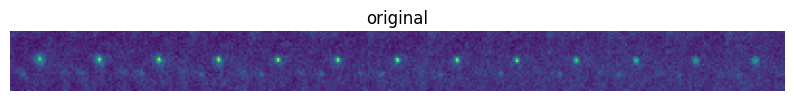

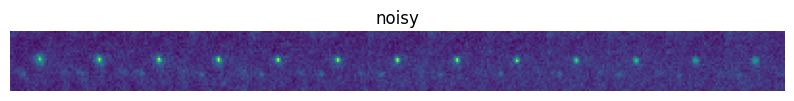

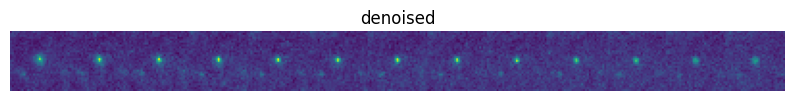

In [15]:
from jax.numpy.fft import fftn, fftshift, ifftn, ifftshift


def mask_psf(img, otf_mask, alpha=0.1, beta=1, plot=False):
    
    fft = fftshift(fftn(img, axes=(1,2)), axes=(1,2))
    

    att_mask = (1 - beta * jnp.exp(-simul.kr ** 2 / (2 * alpha ** 2)))

    
    plt.rcParams["figure.figsize"] = (10, 5)

    mask = att_mask * (otf_mask).astype(int)
    
    if plot:
        show_psf_axial(norm_zero_one(np.real(fft)), 'imag')
        show_psf_axial(norm_zero_one(np.imag(fft)), 'real')        
        plt.imshow(mask)
        plt.show()
        
    fft = fft.at[:].set(jnp.multiply(fft[:], mask))
    
    if plot:
        show_psf_axial(norm_zero_one(np.real(fft)), 'imag_masked')
        show_psf_axial(norm_zero_one(np.imag(fft)), 'real_masked')
        plt.imshow(att_mask)
        plt.colorbar()
        plt.show()
        plt.imshow(np.imag(fft[50]))
        plt.show()
        show_psf_axial(np.imag(fft), 'Masked FFT')
    
    img2 = np.abs(ifftn(ifftshift(fft, axes=(1,2)), axes=(1,2)))
    
    if plot:
        show_psf_axial(img, 'Original')
        show_psf_axial(img2, 'Denoised')
        
    img2[img2<0] = 0
    return img2


target_psf = jnp.array(stacks[0])

BASELINE = 0
QUANTUM_EFFICIENCY = 1
DARK_NOISE = 0
# target_psf = norm_zero_one(simul.get_scalar_psf())
show_psf_axial(target_psf, 'original')

def noise_psf(psf, baseline=BASELINE, qe=QUANTUM_EFFICIENCY, dn=DARK_NOISE, bitdepth=8, plot=False):
    psf = (psf * (2**bitdepth)).astype(int)
    photons = np.random.poisson(psf)
    electrons = jnp.round(photons * qe)
    electrons_out = electrons + np.random.normal(scale=dn, size=psf.shape)
    electrons_out += baseline

    noisy_psf = norm_zero_one(electrons_out)
    
    if plot:
        show_psf_axial(photons, 'photons')
        show_psf_axial(electrons, 'electons')
        show_psf_axial(electrons_out, 'electons out')
        show_psf_axial(noisy_psf, 'noisy')
    return noisy_psf
    

# noisy_psf = noise_psf(target_psf, plot=False)
noisy_psf = target_psf.copy()
show_psf_axial(noisy_psf, 'noisy')

denoised = mask_psf(noisy_psf, otf_mask=simul.kr <= 2.5, alpha=0.01, plot=False)
denoised = norm_zero_one(denoised)
show_psf_axial(denoised, 'denoised')

In [ ]:
import jax 
from jax.example_libraries.optimizers import adam
from functools import partial
from tqdm import trange
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from jax.numpy.fft import fftn, fftshift, ifftn, ifftshift


n_coefs = 12
simul = Simulator(n_coefs=n_coefs, **optical_params)

target_coefs = jax.random.uniform(key=jax.random.PRNGKey(RANDOM_SEED), shape=(n_coefs,))
mask_idx = jnp.array((3))

simul.zerns = simul.zerns.at[mask_idx].set(0)
target_coefs = target_coefs.at[mask_idx].set(0)


# target_coefs = target_coefs.at[:].set(0)
target_coefs = target_coefs.at[5].set(1)

target_offset = 0.3
target_psf = simul.get_scalar_psf(offset=target_offset, zern_coefs=target_coefs)
target_psf = norm_zero_one(target_psf)



# target_psf = simul.get_scalar_psf(offset=0.8, zern_coefs=target_coefs) * 255 * 255
# target_psf = target_psf.astype(np.uint16)
# show_psf_axial(norm_zero_one(target_psf))

import jaxopt
from functools import partial
# from data.prep_for_pr import prep_data_for_PR
from pyotf.utils import prep_data_for_PR
import time
import optax
from jaxopt import OptaxSolver

# mask_idx = tuple([0, 1, 2, 3])

def normalize(psf):
    return psf / psf.sum()

def run_psf_modelling(target_psf, simulator, n_coefs, l1reg=0, l2reg=0, plot=False):

    def diff_func(params, simulator, target_psf, l1reg=l1reg, l2reg=l2reg):
        offset, zern_coefs = params[0], params[1:]
#         zern_coefs[3] = 0
        zerns_coefs = zern_coefs.at[3].set(0)
        psf = simulator.get_scalar_psf(offset=offset, zern_coefs=zern_coefs)
        psf = normalize(psf)
        error = jnp.mean((psf-target_psf)**2) 
#         return error
        l1reg *= ((jnp.sum(jnp.abs(offset)) + jnp.sum(jnp.abs(zern_coefs))))
        l2reg *= (jnp.sum(offset**2) + jnp.sum(zern_coefs**2))

        return error + l1reg + l2reg 


#     target_psf = norm_zero_one(target_psf)
#     target_psf = (2**16 * target_psf).astype(int)
#     target_psf = prep_data_for_PR(target_psf, multiplier=1.01)
    target_psf = normalize(target_psf.astype(float))
#     offset_x0 = jnp.array([0]).astype(jnp.float32)
    
#     offset_x0 += np.random.uniform(-1, 1)
    
    init_params = np.random.uniform(-1, 1, size=(n_coefs+1,))
    
    peak_z = np.argmax(target_psf.max(axis=(1,2)))
    stack_size = target_psf.shape[0]
    z_offset0 =  (stack_size/2) - peak_z
    z_offset0 *= simulator.dz
    init_params[0] = z_offset0
    
    
    zern_coefs_x0 = jnp.array(init_params).astype(np.float32)
    
    zern_coefs_x0 = zern_coefs_x0.at[mask_idx+1].set(0)
    
    print(f'Init params: {zern_coefs_x0}')

    func = partial(diff_func, simulator=simulator, target_psf=target_psf)

    t1 = time.time()
    
    MAX_ITER = 5000

    schedule = optax.warmup_cosine_decay_schedule(
      init_value=0.01,
      peak_value=10,
      warmup_steps=20,
      decay_steps=MAX_ITER,
      end_value=1e-5,
    )

    opt = optax.chain(
      optax.clip(1.0),
      optax.adamw(learning_rate=schedule),
    )

    solver = OptaxSolver(opt=opt, fun=func, tol=1e-15, maxiter=MAX_ITER)
    res = solver.run(init_params=zern_coefs_x0)
    
#     from scipy.optimize import basinhopping
    
#     res = basinhopping(func=func, x0=zern_coefs_x0, niter=100, disp=True)
#     print(res)
    
    t2 = time.time()
    print(f'Time taken: {t2-t1}')
    params, state = res
    
    
    final_error = diff_func(params, simulator, target_psf, 0, 0)

    final_offset, final_zern_coefs = params[0], params[1:]
    print([round(float(p), 5) for p in params])
    print(f'Final error: {final_error:.4E}')
    print(f'Num iters:', state.iter_num)
    
    if plot:
    
        initial_psf = simulator.get_scalar_psf(offset=zern_coefs_x0[0], zern_coefs=zern_coefs_x0[1:])
        final_psf = simulator.get_scalar_psf(offset=params[0], zern_coefs=params[1:])

        center_psf = simulator.get_scalar_psf(offset=0, zern_coefs=params[1:])

        initial_psf = simulator.get_scalar_psf()
        final_psf = final_psf / final_psf.max()
        initial_psf = initial_psf / initial_psf.max()
        target_psf = target_psf / target_psf.max()
        center_psf = center_psf / center_psf.max()
    
        comparison = jnp.concatenate((initial_psf, final_psf, target_psf, center_psf), axis=2)
        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 5)
        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 14)
        
    print('\n')
    return params, float(final_error), zern_coefs_x0

def report_modelling_res(res_params, init_params, target_offset, target_coefs):
    x = ['offset', *(f'zern_{i}' for i in range(n_coefs))]

#     res_params = jnp.concatenate(res_params)
#     init_params = jnp.concatenate(init_params)
    
    target_params = jnp.concatenate([jnp.array([target_offset]), target_coefs])
    plt.rcParams["figure.figsize"] = (10, 5)
    avg_error = np.mean(abs(res_params[1:]-target_params[1:]))
    plt.scatter(x, res_params, marker='.', label='solution')
    plt.scatter(x, target_params, marker='x', label='target')
    plt.scatter(x, init_params, marker='x', label='init')

    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

    
l1reg = 0
l2reg = 1e-7

print(target_offset, target_coefs)
# target_psf = stacks[4]
target_psf = np.array(target_psf).astype(np.float64)
target_psf = noise_psf(target_psf)

target_psf = mask_psf(target_psf, otf_mask=simul.kr <= 2, alpha=0.1, plot=False)
show_psf_axial(target_psf)
res = []
min_error = np.inf
for i in range(20):
    params, error, init_params = run_psf_modelling(target_psf.astype(np.float64), simul, n_coefs, l1reg, l2reg, plot=False)
    res.append(list(params) + [error])
#     report_modelling_res(params, init_params, target_offset, target_coefs)
    if error < min_error:
        min_error = error
        print(f'Min error {min_error}')

    
cols = ['offset', *(f'zern_{i}' for i in range(n_coefs)), 'error']
res = pd.DataFrame(res, columns=cols, dtype='float')
res = res[res['error'] < np.percentile(res['error'], 25)]
res.boxplot()
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(f"{res['error'].mean():.4e}")

In [ ]:
import jax 
from jax.example_libraries.optimizers import adam
from functools import partial
from tqdm import trange
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from jax.numpy.fft import fftn, fftshift, ifftn, ifftshift


n_coefs = 16
simul = Simulator(n_coefs=n_coefs, **optical_params)
target_coefs = jax.random.uniform(key=jax.random.PRNGKey(RANDOM_SEED), shape=(n_coefs,))
target_coefs = target_coefs.at[0].set(0)
target_coefs = target_coefs.at[3].set(0)

# target_coefs = target_coefs.at[:].set(0)
target_coefs = target_coefs.at[5].set(0.5)

target_offset = 0.3
target_psf = simul.get_scalar_psf(offset=target_offset, zern_coefs=target_coefs)
target_psf = norm_zero_one(target_psf)



# target_psf = simul.get_scalar_psf(offset=0.8, zern_coefs=target_coefs) * 255 * 255
# target_psf = target_psf.astype(np.uint16)
# show_psf_axial(norm_zero_one(target_psf))

import jaxopt
from functools import partial
# from data.prep_for_pr import prep_data_for_PR
from pyotf.utils import prep_data_for_PR
import time
import optax
from jaxopt import OptaxSolver


def run_psf_modelling(target_psf, simulator, n_coefs, l1reg=0, l2reg=0, plot=False):

    def diff_func(params, simulator, target_psf, l1reg=l1reg, l2reg=l2reg):
        offset, zern_coefs = params
        zerns_coefs = zern_coefs.at[3].set(0)
        psf = simulator.get_scalar_psf(offset=offset, zern_coefs=zern_coefs)
        psf = norm_zero_one(psf)
        error = jnp.mean((psf-target_psf)**2) 
#         return error
        l1reg *= ((jnp.sum(jnp.abs(offset)) + jnp.sum(jnp.abs(zern_coefs))))
        l2reg *= (jnp.sum(offset**2) + jnp.sum(zern_coefs**2))

        return error + l1reg + l2reg 

    target_psf = norm_zero_one(target_psf)
    target_psf = (2**16 * target_psf).astype(int)
    target_psf = prep_data_for_PR(target_psf, multiplier=1.01)
    target_psf = norm_zero_one(target_psf.astype(float))
    offset_x0 = jnp.array([0]).astype(jnp.float32)
    
#     zern_coefs_x0 = jnp.array([0] * n_coefs).astype(jnp.float32)
    zern_coefs_x0 = jax.random.uniform(key=jax.random.PRNGKey(42), shape=(n_coefs,))
    
    func = partial(diff_func, simulator=simulator, target_psf=target_psf)

    t1 = time.time()
    
    schedule = optax.warmup_cosine_decay_schedule(
      init_value=0.1,
      peak_value=0.1,
      warmup_steps=0,
      decay_steps=1_000,
      end_value=0.0,
    )

    opt = optax.chain(
      optax.clip(1.0),
      optax.adamw(learning_rate=schedule),
    )

    solver = OptaxSolver(opt=opt, fun=func, tol=1e-12, maxiter=1000)
    res = solver.run(init_params=(offset_x0, zern_coefs_x0))

    
#     opt = jaxopt.BFGS(func, tol=1e-9, maxiter=1000)
#     res = opt.run(init_params=(offset_x0, zern_coefs_x0))

    t2 = time.time()

    print(f'Time taken: {t2-t1}')
    params, state = res
    
    
    final_error = diff_func(params, simulator, target_psf, 0, 0)

    final_offset, final_zern_coefs = params
    print(params)
    print(f'Final error: {final_error:.4E}')
    print(f'Num iters:', state.iter_num)
    
    if plot:
    
        initial_psf = simulator.get_scalar_psf(offset=offset_x0, zern_coefs=zern_coefs_x0)
        final_psf = simulator.get_scalar_psf(offset=final_offset, zern_coefs=final_zern_coefs)

        center_psf = simulator.get_scalar_psf(offset=0, zern_coefs=final_zern_coefs)

        initial_psf = simulator.get_scalar_psf()
        final_psf = final_psf / final_psf.max()
        initial_psf = initial_psf / initial_psf.max()
        target_psf = target_psf / target_psf.max()
        center_psf = center_psf / center_psf.max()
    
        comparison = jnp.concatenate((initial_psf, final_psf, target_psf, center_psf), axis=2)
        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 5)
        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 14)
        final_psf = norm_zero_one(final_psf)
        target_psf = norm
        plt.plot(final_psf.max(axis=(1,2)), label='final')
        plt.plot(target_psf.mean(axis=(1,2)), label='target')
        plt.legend()
        plt.show()

    return params, float(final_error)

def report_modelling_res(res_params):
    x = ['offset', *(f'zern_{i}' for i in range(n_coefs))]

    res_params = jnp.concatenate(res_params)
    target_params = jnp.concatenate([jnp.array([target_offset]), target_coefs])
    plt.rcParams["figure.figsize"] = (10, 5)
    avg_error = np.mean(abs(res_params[1:]-target_params[1:]))
    plt.scatter(x, res_params, marker='.', label='solution')
    plt.scatter(x, target_params, marker='x', label='target')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

l1reg = 1e-5
l2reg = 0

target_psf = stacks[0]
show_psf_axial(target_psf)

# Noise free
params, error = run_psf_modelling(target_psf, simul, n_coefs, l1reg, l2reg, plot=False)
# report_modelling_res(params)

# With noise
# show_psf_axial(target_psf)
# noisy_psf = noise_psf(target_psf, dn=200, baseline=100, plot=False, qe=0.69, bitdepth=16)
# params, error = run_psf_modelling(noisy_psf, simul, n_coefs, l1reg, l2reg, plot=True)
# report_modelling_res(params)


# Denoised
denoised = mask_psf(target_psf, otf_mask=simul.kr <= 2, alpha=0.3, plot=False)
show_psf_axial(denoised)
denoised = norm_zero_one(denoised)
params, error = run_psf_modelling(denoised, simul, n_coefs, l1reg, l2reg, plot=True)
# report_modelling_res(params)


Stacks (10, 150, 31, 31)
0.0 1.0


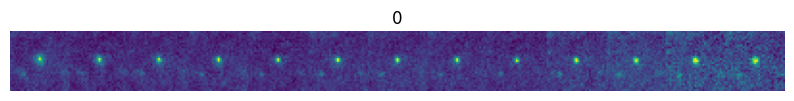

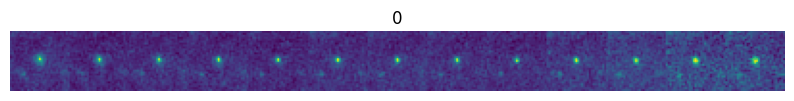

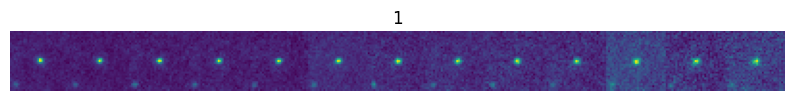

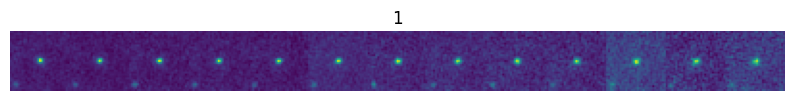

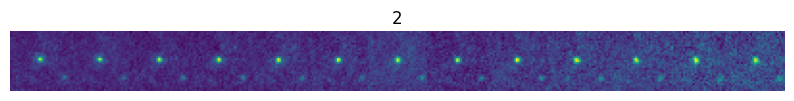

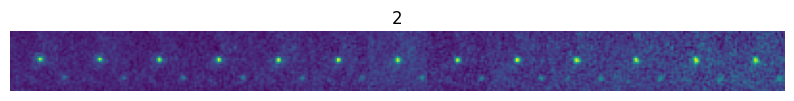

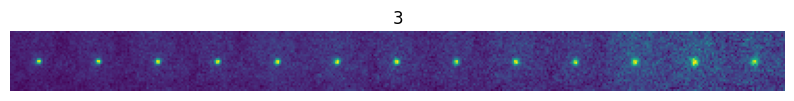

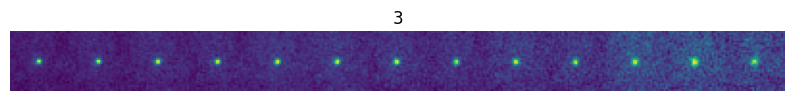

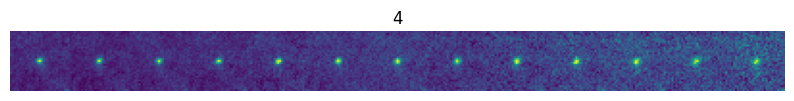

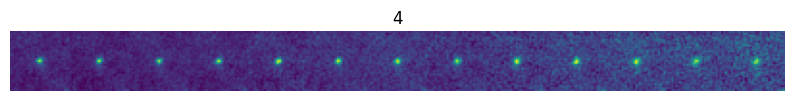

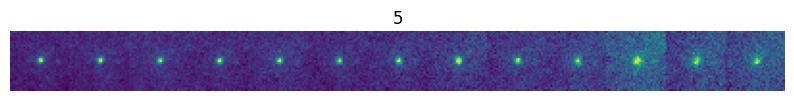

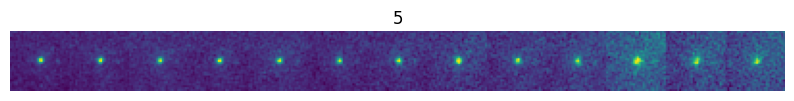

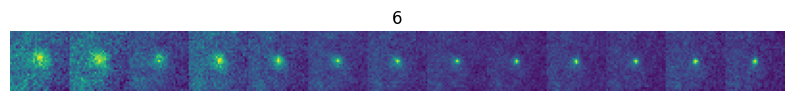

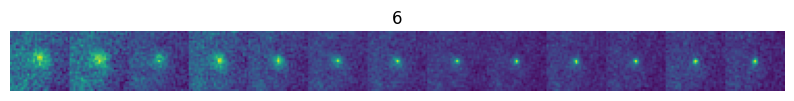

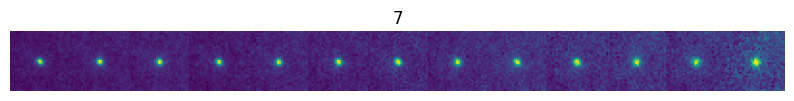

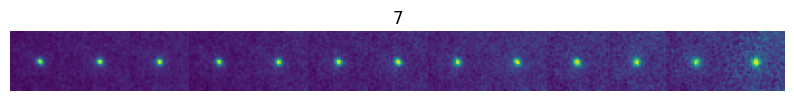

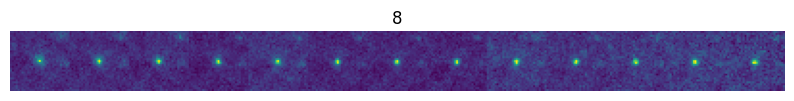

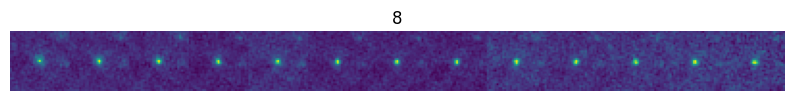

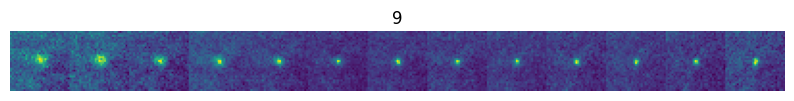

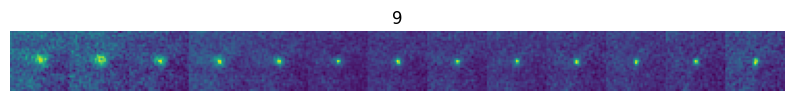

In [113]:
try:
    from smlm_z.pipelines.preprocessing.nodes import resize_stacks, norm_stacks
except ImportError:
    from smlm_z.pipelines.preprocessing.nodes import resize_stacks, norm_stacks
stacks_min, stacks_max, stacks_dtype = stacks.min(), stacks.max(), stacks.dtype
# stacks = resize_stacks(stacks, target_shape=(stacks.shape[1], 32, 32))
# stacks = norm_stacks(stacks)
print(stacks.min(), stacks.max())

masked_stacks = []
for i in range(stacks.shape[0]):
    show_psf_axial(stacks[i], str(i))
    s = mask_psf(stacks[i], otf_mask=simul.kr <= 2, alpha=0.01, plot=False)
    s = norm_zero_one(s)
    show_psf_axial(s, str(i))
    masked_stacks.append(s)

masked_stacks = np.stack(masked_stacks)

# stacks -= stacks.min()
# stacks = stacks / stacks.max()
# stacks *= (stacks_max - stacks_min)
# stacks += stacks_min
# stacks = stacks.astype(stacks_dtype)


In [ ]:
from tqdm import trange
import itertools
from hyperopt import fmin, tpe, STATUS_OK, hp
from functools import partial


target_psfs = masked_stacks[:20, :150]


In [ ]:
from sklearn.metrics import mean_squared_error

n_coefs = 32
simul = Simulator(n_coefs=n_coefs, **optical_params)

def run_psf_modelling2(target_psf, simulator, n_coefs, opt, lr, l1reg=0, l2reg=0, plots=False, get_params=False):

    def diff_func(params, simulator, target_psf, l1reg=l1reg, l2reg=l2reg):
        offset, zern_coefs = params
        zerns_coefs = zern_coefs.at[3].set(0)
        psf = simulator.get_scalar_psf(offset=offset, zern_coefs=zern_coefs)
        psf = norm_zero_one(psf)
        error = jnp.mean((psf-target_psf)**2) 
#         return error
        l1reg *= ((jnp.sum(jnp.abs(offset)) + jnp.sum(jnp.abs(zern_coefs))))
        l2reg *= (jnp.sum(offset**2) + jnp.sum(zern_coefs**2))
        return error + l1reg + l2reg 
    
    offset_x0 = jnp.array([0]).astype(jnp.float32)
    zern_coefs_x0 = jnp.array([0] * n_coefs).astype(jnp.float32)
    
    func = partial(diff_func, simulator=simulator, target_psf=target_psf)

    solver = OptaxSolver(opt=opt(lr), fun=func, tol=1e-6, maxiter=300)
    res = solver.run(init_params=(offset_x0, zern_coefs_x0))
    
    params, state = res
    if get_params:
        return params
    
    final_error = diff_func(params, simulator, target_psf, 0, 0)    
    
    if plots:
        final_error = diff_func(params, simulator, target_psf, 0, 0)

        initial_psf = simulator.get_scalar_psf(offset=offset_x0, zern_coefs=zern_coefs_x0)

        final_offset, final_zern_coefs = params
        final_psf = simulator.get_scalar_psf(offset=final_offset, zern_coefs=final_zern_coefs)

        center_psf = simulator.get_scalar_psf(offset=0, zern_coefs=final_zern_coefs)

        initial_psf = simulator.get_scalar_psf()
        final_psf = final_psf / final_psf.max()
        initial_psf = initial_psf / initial_psf.max()
        target_psf = target_psf / target_psf.max()
        center_psf = center_psf / center_psf.max()

        comparison = jnp.concatenate((initial_psf, final_psf, target_psf, center_psf), axis=2)

        print(params)
        print(f'Final error: {final_error:.4E}')
        print(f'Num iters:', state.iter_num)

        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 5)
        plt.title('Initial - Final - Target - Centered')
        show_psf_axial(comparison, '', 14)

    return float(final_error)

opts = [
    optax.rmsprop,
    optax.adam,
    optax.sgd,
    optax.adamax,
    optax.adagrad,
    optax.adamw
]


space = [
    hp.choice('opt', opts),
    hp.loguniform('lr', -10, 3),
    hp.loguniform('l1reg', -10, -1),
    hp.loguniform('l2reg', -10, -1),
]

def func(params):
    opt, lr, l1reg, l2reg = params
    errors = [run_psf_modelling2(s, simul, n_coefs, opt, lr, l1reg, l2reg, plots=False) for s in target_psfs]
    return np.mean(np.power(errors, 2))
    
# best = fmin(fn=func, space=space, algo=tpe.suggest, max_evals=300)

# with open('results.txt', 'w') as f:
#     f.write(str(best))

# print(best)
# res = []


#     for params in tqdm(list(itertools.product(*[opts, lrs, reg, reg]))):
#         opt, lr, l1reg, l2reg = params
#         error = run_psf_modelling(target_psf, simul, n_coefs, opt, lr, l1reg, l2reg)
#         res.append({
#             'i': i,
#             'opt': opt.__name__,
#             'lr': lr,
#             'l1reg': l1reg,
#             'l2reg': l2reg,
#             'error': error
#         })

In [ ]:
l1reg = best['l1reg']
l2reg = best['l2reg']
# l1reg, l2reg = 0.001, 0.001
lr = best['lr']
opt = optax.adamw
print(l1reg, l2reg, lr, opt)
params = run_psf_modelling2(target_psfs[0], simul, n_coefs, opt, lr, l1reg, l2reg, plots=True)
# errors = [run_psf_modelling(s, simul, n_coefs, opt, lr, l1reg, l2reg, plots=True) for s in target_psfs]
# print(sum(np.power(errors, 2)) / len(errors))

  0%|                                                                                                                                                                                | 0/87 [00:00<?, ?it/s]

Init params: [ 0.5        -0.7394283  -0.1962843  -0.24049725  0.          0.1965218
 -0.23431131  0.05714759 -0.42941716]
Time taken: 2.9249932765960693
[0.20464, -0.74314, -0.68064, 0.0809, 0.0, -0.04612, 0.32267, 0.09969, -0.92978]
Final error: 1.6167E-03
Num iters: 1000


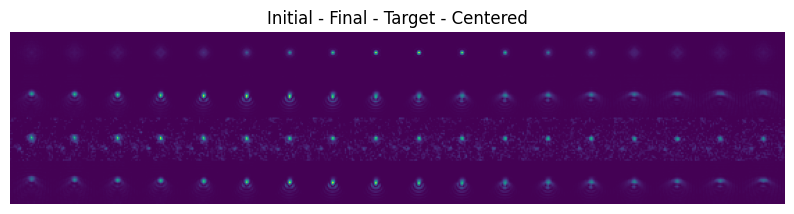

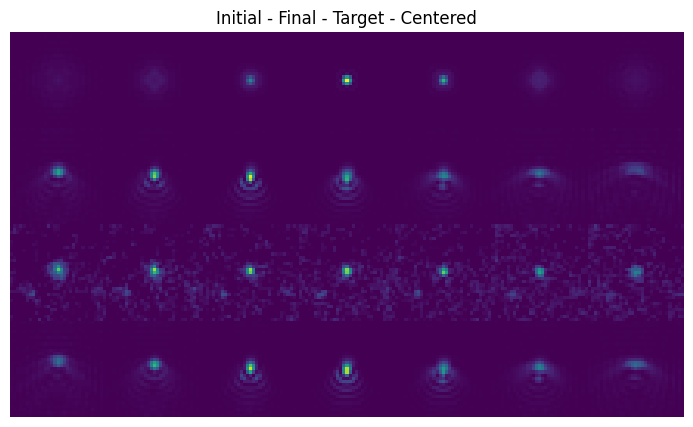

  1%|█▉                                                                                                                                                                      | 1/87 [00:03<04:59,  3.48s/it]



Init params: [ 0.84        0.48659763  0.6196754  -0.863571    0.          0.7777372
 -0.3863637  -0.77207994  0.30743143]
Time taken: 2.8699681758880615
[0.7525, 0.4746, 0.01822, -0.98572, 0.0, 0.36969, -0.02649, -0.70074, -0.15956]
Final error: 1.0498E-03
Num iters: 1000


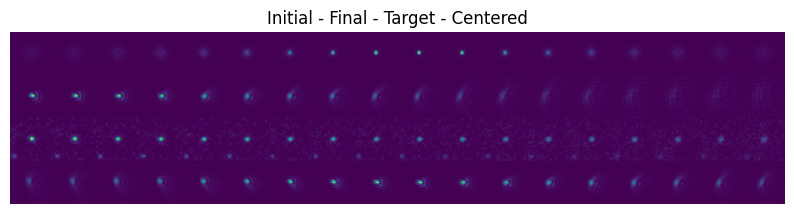

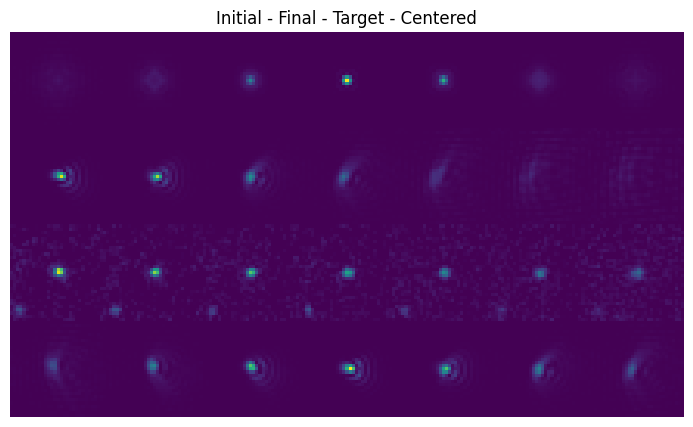

  2%|███▊                                                                                                                                                                    | 2/87 [00:06<04:54,  3.47s/it]



Init params: [ 0.72        0.17040873  0.7915548   0.14941728  0.          0.37278336
 -0.9158943  -0.9213767   0.3857117 ]
Time taken: 2.860570192337036
[0.70141, 0.1739, 0.90163, -0.43091, 0.0, 0.44784, -0.4638, -0.19587, 0.26943]
Final error: 1.5173E-03
Num iters: 1000


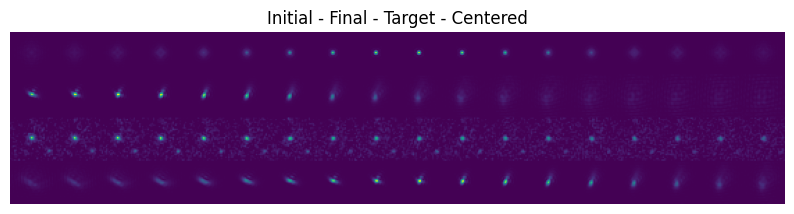

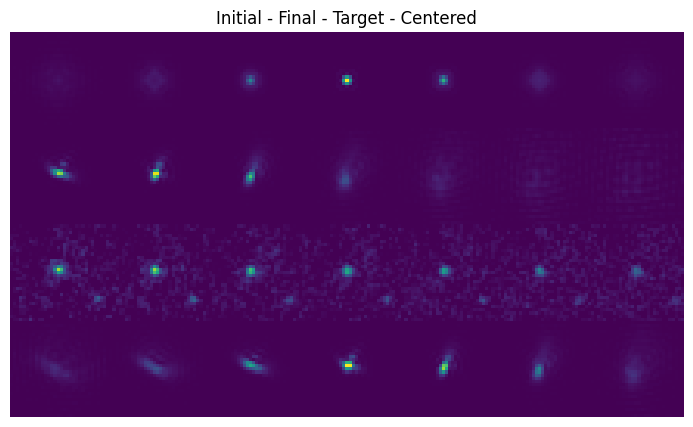

  3%|█████▊                                                                                                                                                                  | 3/87 [00:10<04:49,  3.45s/it]



Init params: [ 1.08       -0.5209206   0.2586065  -0.23624557  0.          0.28171745
  0.01761633  0.2275797   0.12389404]


  3%|█████▊                                                                                                                                                                  | 3/87 [00:13<06:10,  4.41s/it]


KeyboardInterrupt: 

In [151]:
results = []
from tqdm import trange
from pyotf.utils import remove_bg

n_coefs = 8
simul = Simulator(n_coefs=n_coefs, **optical_params)

for i in trange(stacks.shape[0]):
    psf = stacks[i][:150]
    target_psf = mask_psf(psf, otf_mask=simul.kr <= 2, alpha=0.05, plot=False)
    loc = locs.iloc[i]
    params, error, init_params = run_psf_modelling(target_psf, simul, n_coefs, l1reg=0, l2reg=0, plot=True)
    res = {
        'x': loc['x'],
        'y': loc['y'],
        'grad': loc['net_gradient'],
        'error': error,
        'params': np.array(params)
    }
    for i2, val in enumerate(params[1:]):
        res[f'zern_coef_{i2}'] = float(val)
    res['offset'] = float(params[0])
    results.append(res)
df = pd.DataFrame.from_records(results)
print(df['error'].mean())
# 0.007444613659754395

In [139]:
print(np.mean(df['error']))

0.001646565544036292


1.6466E-03
(87, 19)
(87, 19)


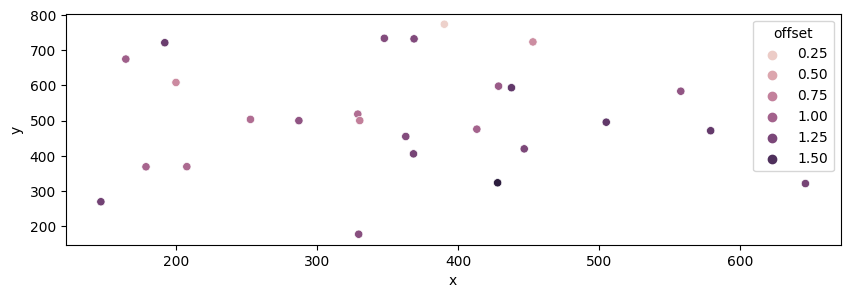

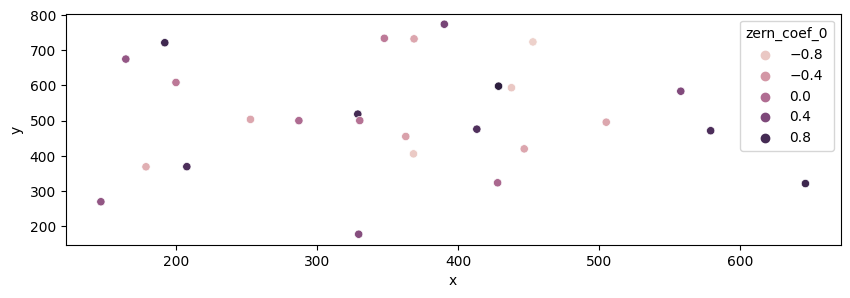

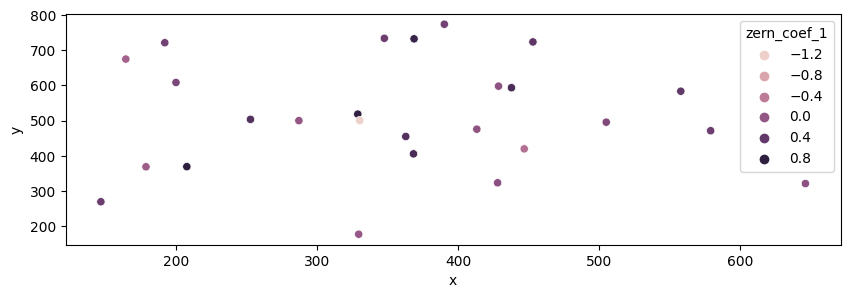

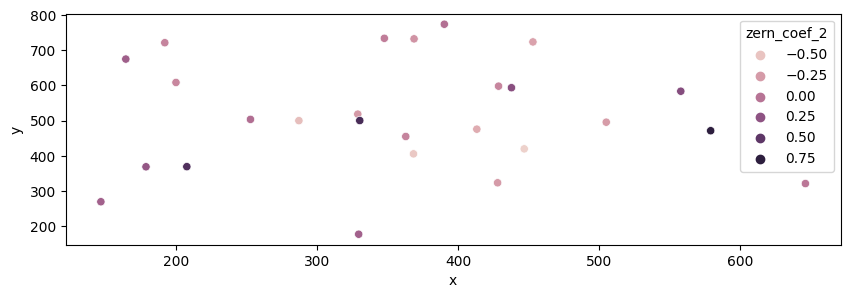

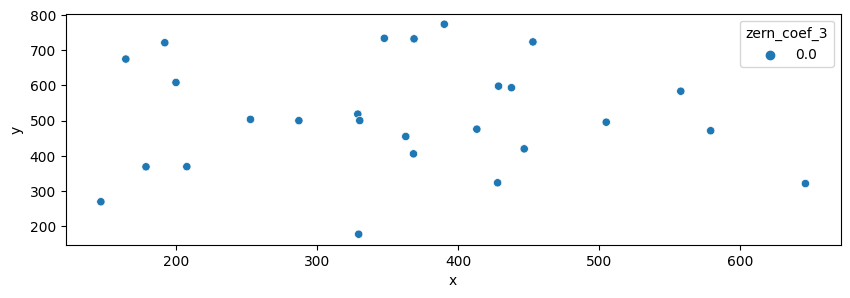

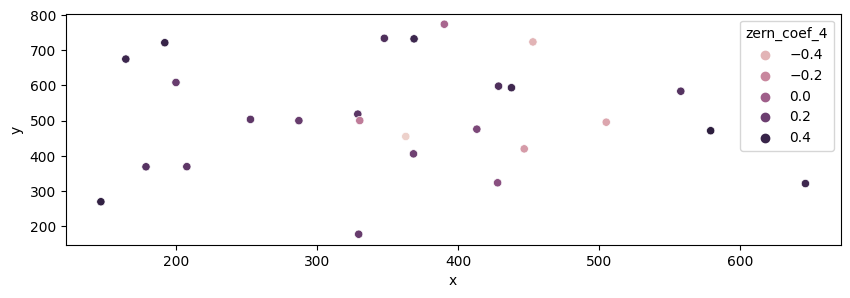

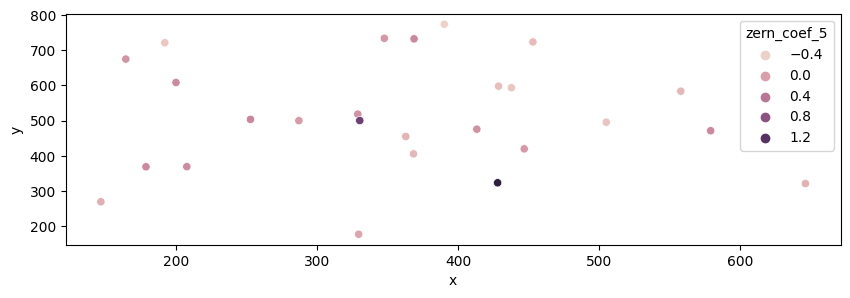

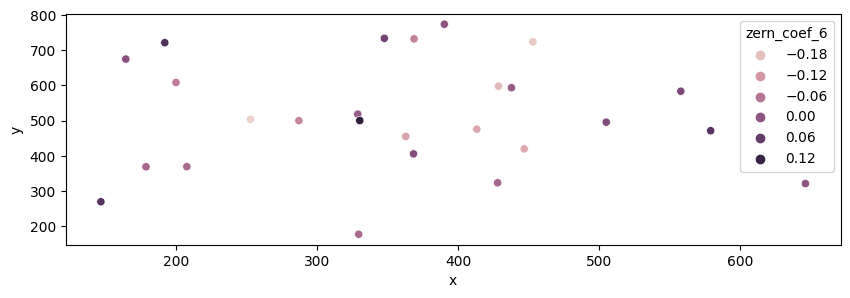

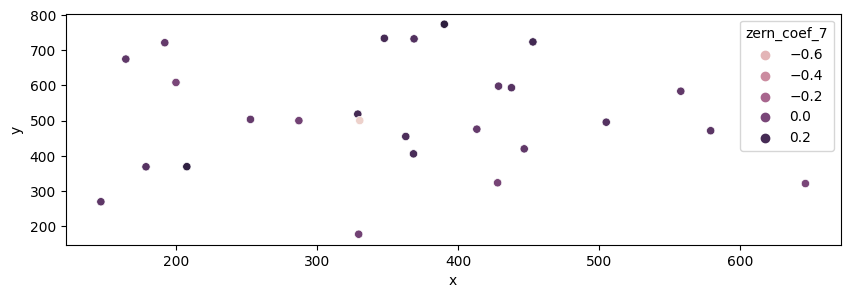

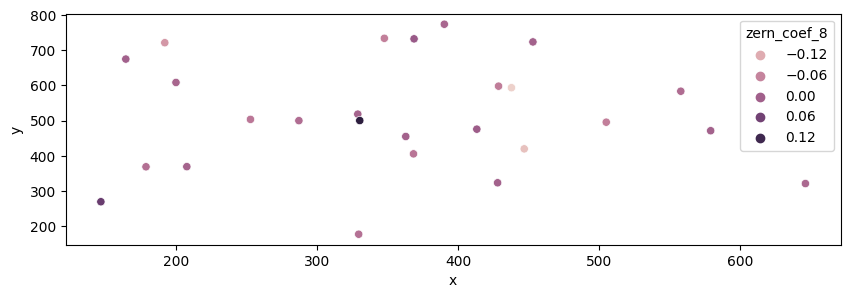

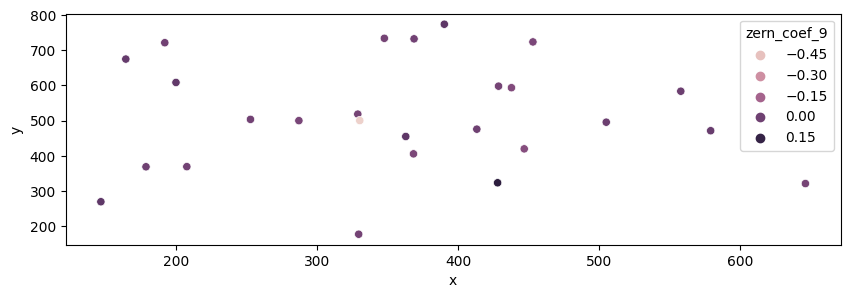

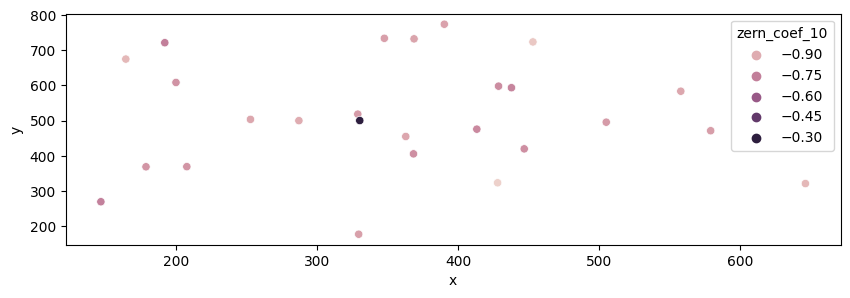

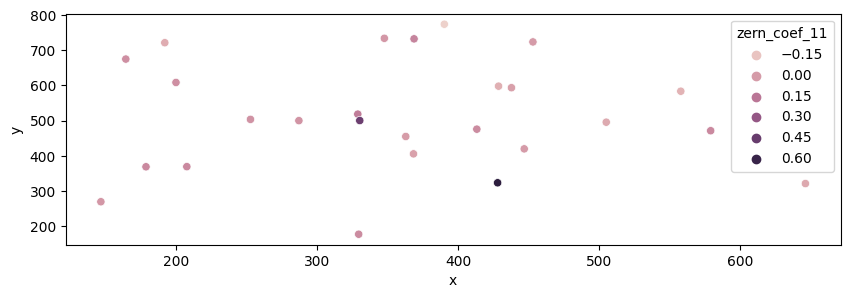

In [146]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 3)

df = pd.DataFrame.from_records(results)
print(f'{df["error"].mean():.4E}')
df['param_sum'] = df['params'].apply(lambda x: sum(abs(np.array(x))))

print(df.shape)
df = df[df['param_sum'] < 100]
print(df.shape)
idx = df['error'] <= 1e-3
df = df[idx]


# corr = df.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)
# plt.show()

# sns.scatterplot(data=df, x='param_sum', y='error')
# plt.yscale('log')
# plt.show()

sns.scatterplot(data=df, x='x', y='y', hue='offset')
plt.show()

for c in list(df):
    if 'coef' in c:
        sns.scatterplot(data=df, x='x', y='y', hue=c)
        plt.show()

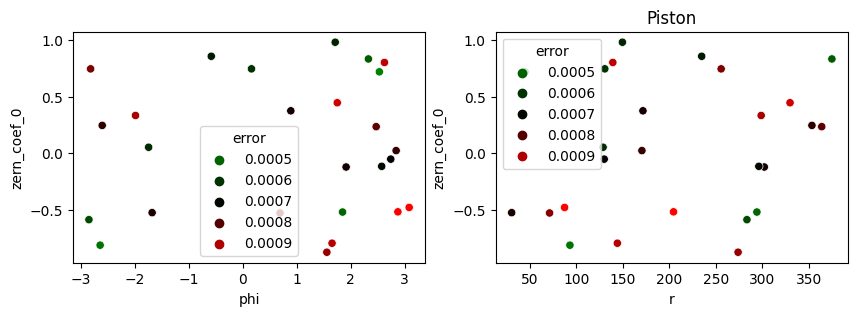

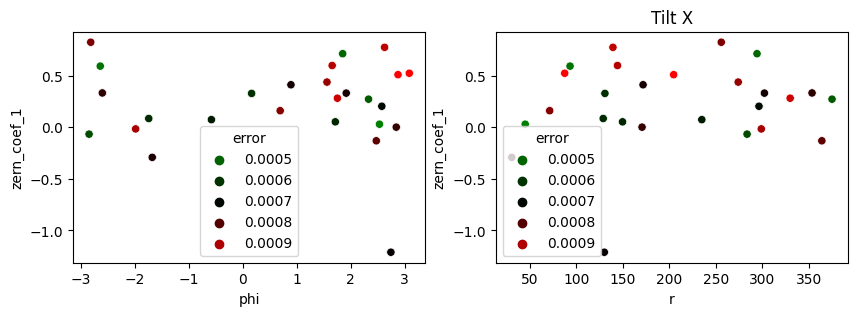

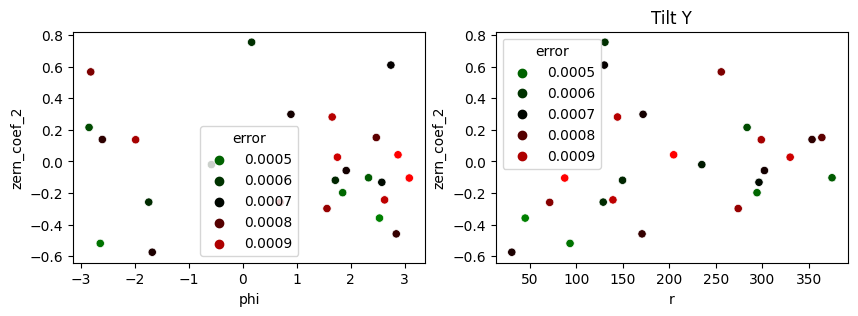

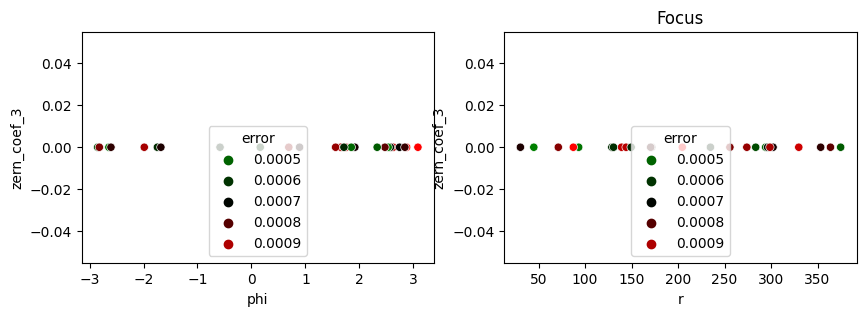

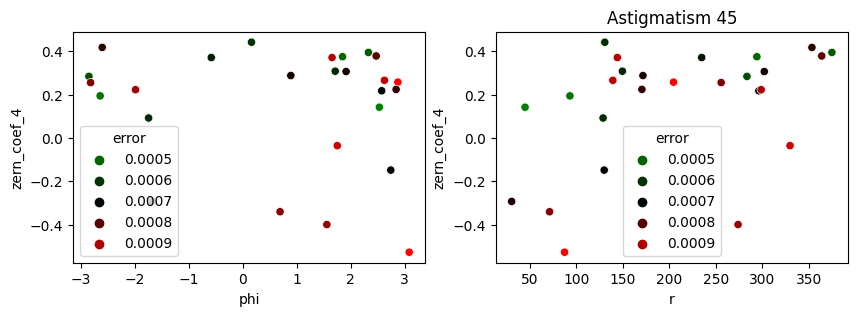

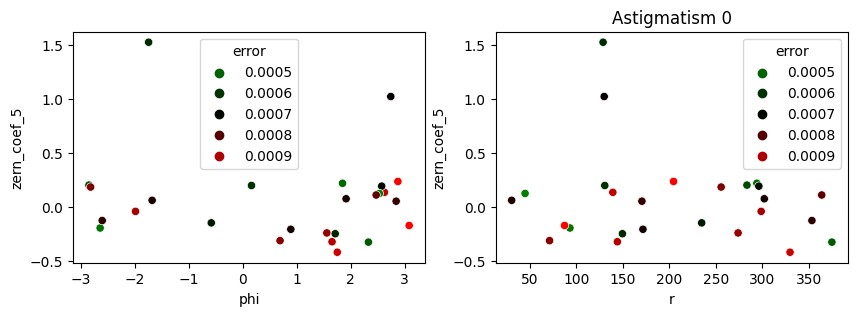

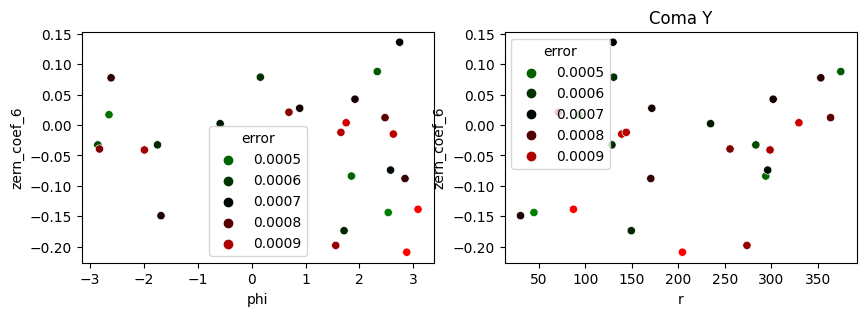

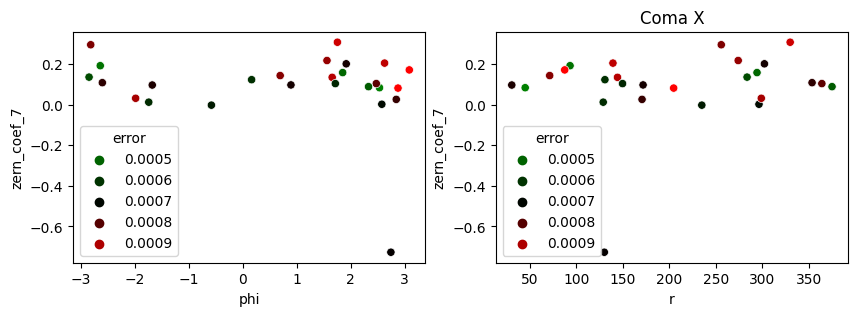

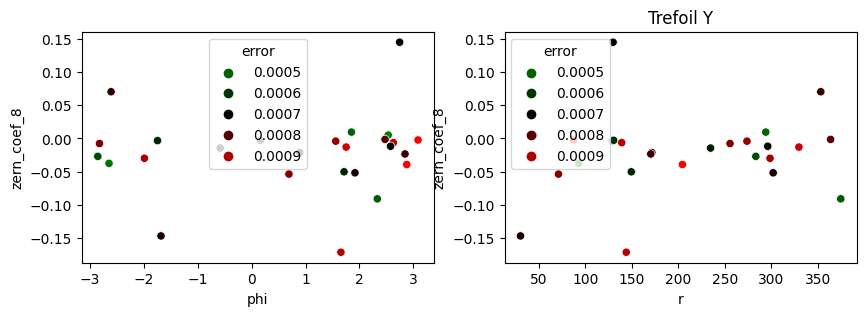

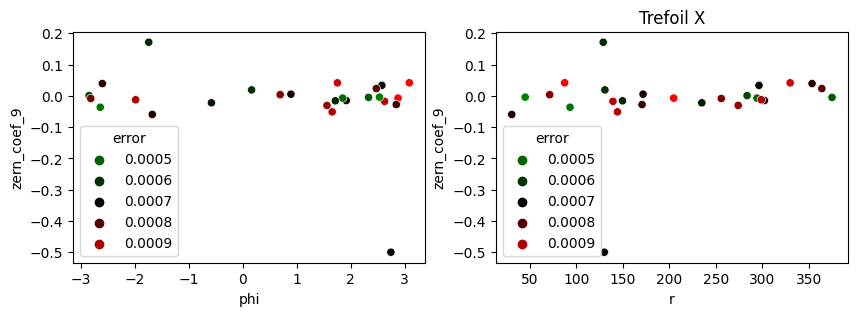

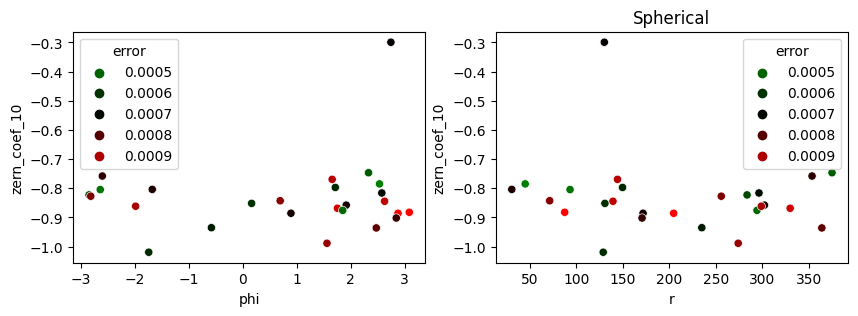

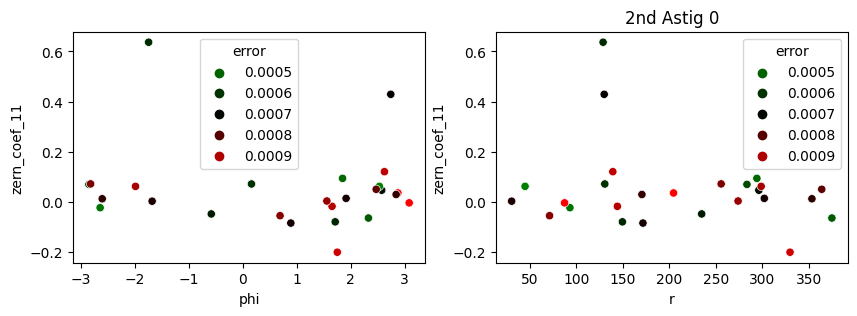

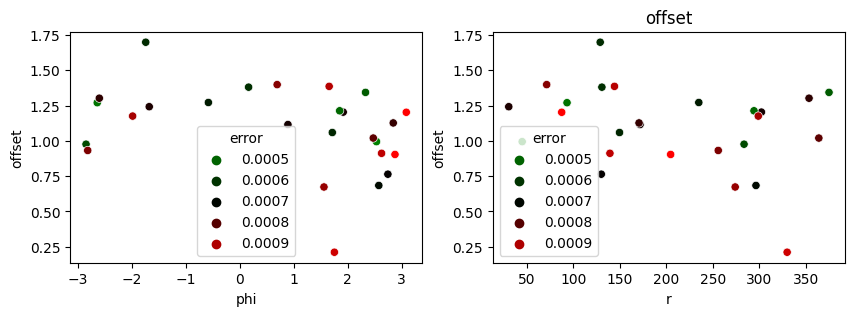

In [145]:
df2 = df.copy()
df2['x'] -= 450
df2['y'] -= 450

df2 = df2[df2['error'] < 1e-3]
# Define a function to convert cartesian coordinates to polar coordinates
def cartesian_to_polar(x, y):
    radius = np.sqrt(x**2 + y**2)
    angle = np.arctan2(y, x)
    return radius, angle

# Apply the conversion function to each row of the DataFrame
df2['r'], df2['phi'] = zip(*df2.apply(lambda row: cartesian_to_polar(row['x'], row['y']), axis=1))

from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('gr',['g', 'black', 'r'], N=64) 

plt.rcParams["figure.figsize"] = (10, 3)

for c in list(df):
    if 'coef' in c or 'offset' in c:
        f, axs = plt.subplots(1, 2)
        if 'coef' in c:
            coef_id = int(c.split('_')[-1]) + 1
            title = poppy.zernike.zern_name(coef_id)
        else:
            title = 'offset'
        plt.title(title)
        sns.scatterplot(data=df2, x='phi', y=c, hue='error', ax=axs[0], palette=cmap)
        sns.scatterplot(data=df2, x='r', y=c, hue='error', ax=axs[1], palette=cmap)
        plt.show()
        

In [142]:
df['x_norm'] = norm_zero_one(df['x'])
df['y_norm'] = norm_zero_one(df['y'])

In [ ]:
show_psf_axial(stacks[4])

In [ ]:
from smlm_z.pipelines.preprocessing.nodes import norm_images, resize_stacks
from data.estimate_offset import get_peak_sharpness

# Eval data
stack_psfs = stacks

val_zs = []
val_xy = []
val_psfs = []
for i in range(stack_psfs.shape[0]):
    psf = stack_psfs[i]
    
#     peak = int(get_peak_sharpness(psf))
#     z_range = 1.0
#     n_slices_from_focus = int(z_range / z_step)
#     start = max((peak-n_slices_from_focus, 0))
#     end = min((peak+n_slices_from_focus, psf.shape[0]))
    
#     psf = psf[start:end]
    peak = 0
    val_zs.append((np.arange(psf.shape[0])-peak) * z_step * 1000)
    xy_coords = df.iloc[i][['x_norm', 'y_norm']].tolist()
#     xy_coords = [0, 0]
    val_xy.append(xy_coords)
    val_psfs.append(psf.astype(float))
#     show_psf_axial(stack_psfs[i])

val_xy = np.array(val_xy)
val_zs = np.array(val_zs)
for i in range(len(val_psfs)):
    val_psfs[i] = norm_images(val_psfs[i])
    val_psfs[i] = val_psfs[i][:, :, :, np.newaxis]
    val_psfs[i] = np.repeat(val_psfs[i], 3, axis=-1)

# show_psf_axial(val_psfs[i].mean(axis=-1))

print(val_xy.shape)
print(val_zs.shape)

In [ ]:
from tqdm import tqdm
train_psfs = []
train_zs = []
train_xy = []
for entry in df.to_dict(orient='records'):
    psf = simul.get_scalar_psf(offset=0, zern_coefs=entry['params'][1])
    plt.rcParams["figure.figsize"] = (10, 10)
    show_psf_axial(psf)

    psf = norm_images(psf)[:, :, :, np.newaxis]
    psf = np.repeat(psf, 3, axis=-1)
    zs = np.linspace(-simul.zrange, simul.zrange-simul.dz, psf.shape[0]) * 1000
    train_psfs.append(psf)
    train_zs.append(zs)
    xy_coords = [entry['x_norm'], entry['y_norm']]
    for _ in range(psf.shape[0]):
        train_xy.append(xy_coords)

train_psfs = np.concatenate(train_psfs)

train_xy = np.array(train_xy)
train_zs = np.array(train_zs).flatten()[:, np.newaxis]
print(train_psfs.shape)
print(train_xy.shape)
print(train_zs.shape)

X = (train_psfs, train_xy)
y = train_zs

In [ ]:
params = {
    'train_size': 0.8, 
    'test_size': 0.1, 
    'val_size': 0.1, 
    'random_seed': 42,
    'training': {
        'learning_rate': 1e-4,
        'batch_size': 128,
        'max_epochs': 1000,
        'aug_ratio': 4
    },
    'data_augmentation': {
        'noise_std': 0.3,
        'max_lateral_translation_px': 2,
    },
    'model_input_shape': [32, 32, 3],
    
}

In [ ]:
%load_ext autoreload
%autoreload 2
from smlm_z.pipelines.train_model.nodes import split_train_val_test, train_classifier, check_data, augment_datasets, check_data

X_train, y_train, X_val, y_val, X_test, y_test = split_train_val_test(X, y, params)

print(X_train[0].shape, X_train[1].shape, y_train.shape)
X_train, y_train = augment_datasets(X_train, y_train, params)
print(X_train[0].shape, X_train[1].shape, y_train.shape)
plt.rcParams["figure.figsize"] = (3, 3)
# check_data(X_train, y_train, X_val, y_val, X_test, y_test)

X_exp, y_exp = (np.concatenate(val_psfs), val_xy), np.concatenate(val_zs)
print(X_exp[0].shape, X_exp[1].shape, y_exp.shape)

check_data(X_train, y_train, X_val, y_val, X_exp, y_exp)

In [ ]:
backup = {}
backup['X_train'] = X_train
backup['X_val'] = X_val
backup['X_test'] = X_test
backup['y_train'] = y_train
backup['y_val'] = y_val
backup['y_test'] = y_test
backup['val_psfs'] = val_psfs
backup['val_xy'] = val_xy
backup['val_zs'] = val_zs

SAVE=True
import os
import pickle
os.makedirs('./backup', exist_ok=True)
if SAVE:
    for k, v in backup.items():
        fpath = f'./backup/{k}.pickle'
        with open(fpath,'wb') as f:
            pickle.dump(v, f)
